In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2
%load_ext autotime
import rpy2.robjects.lib.ggplot2 as ggplot2
import pandas as pd
import matplotlib.pyplot as plt
from utils_child import analysis
import importlib
importlib.reload(analysis)
%R library(plotROC)
%R library('pROC')

R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following object is masked from ‘package:plotROC’:

    ggroc


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var




array(['pROC', 'plotROC', 'ggplot2', 'lazyeval', 'rlang', 'tools',
       'stats', 'graphics', 'grDevices', 'utils', 'datasets', 'methods',
       'base'], dtype='<U9')

time: 7.21 s (started: 2022-02-05 17:04:06 -08:00)


<Figure size 432x288 with 0 Axes>

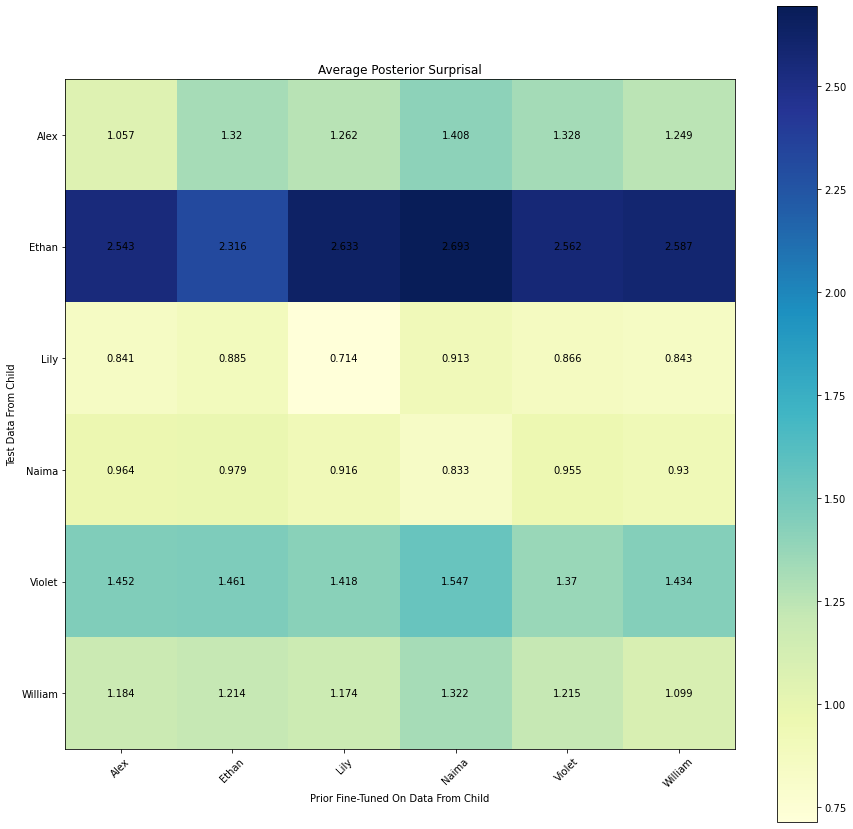

time: 18.3 s (started: 2022-02-05 17:04:14 -08:00)


In [2]:
posterior_plot = analysis.get_success_scores(is_mean = True, which_key = 'posterior_probability', likelihood_type = 'wfst')
plt.rcParams.update({'font.size': 24})
plt.savefig('figures/child_cross_wfst_posterior.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

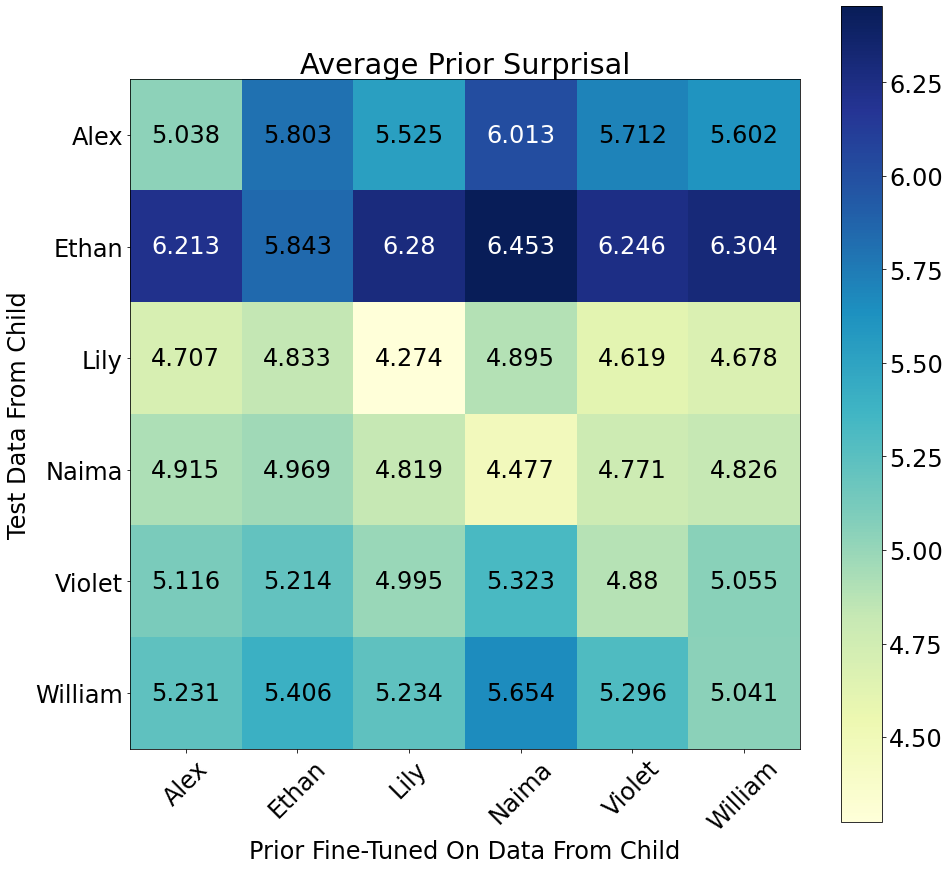

time: 18.1 s (started: 2022-02-05 17:04:32 -08:00)


In [3]:
prior_plt = analysis.get_success_scores(is_mean = True, which_key = 'prior_probability', likelihood_type = 'wfst')
plt.rcParams.update({'font.size': 24})
plt.savefig('figures/child_cross_wfst_prior.pdf')
plt.show()

# Analyzing failures

In [4]:
import importlib
importlib.reload(analysis)


cross_scores = analysis.load_all_scores() 
print(cross_scores.shape[0])

cross_scores = cross_scores.loc[cross_scores.likelihood_type == 'wfst']
print(cross_scores.shape[0])

cross_scores['token'] = cross_scores['token'].astype(str)
cross_scores_short = cross_scores[['cross_type', 'data_child', 'prior_child', 'posterior_probability','posterior_entropy','prior_probability',
    'kl_flat_to_prior', 'kl_flat_to_posterior','set','token','bert_token_id', 'edit_distance']]

%R -i cross_scores_short

567780
283890
time: 41.6 s (started: 2022-02-05 17:04:50 -08:00)


In [5]:
%%R
cross_scores_short$set_binarized = 0
cross_scores_short$set_binarized[cross_scores_short$set == 'failure'] = 1
table(cross_scores_short$set_binarized)


     0      1 
248166  35724 
time: 171 ms (started: 2022-02-05 17:05:32 -08:00)


In [6]:
%%R
# Get AUC scores into these
unique(as.character(cross_scores_short$cross_type))

 [1] "data-Alex+prior_child-Alex"       "data-Alex+prior_child-Ethan"     
 [3] "data-Alex+prior_child-Lily"       "data-Alex+prior_child-Naima"     
 [5] "data-Alex+prior_child-Violet"     "data-Alex+prior_child-William"   
 [7] "data-Ethan+prior_child-Alex"      "data-Ethan+prior_child-Ethan"    
 [9] "data-Ethan+prior_child-Lily"      "data-Ethan+prior_child-Naima"    
[11] "data-Ethan+prior_child-Violet"    "data-Ethan+prior_child-William"  
[13] "data-Lily+prior_child-Alex"       "data-Lily+prior_child-Ethan"     
[15] "data-Lily+prior_child-Lily"       "data-Lily+prior_child-Naima"     
[17] "data-Lily+prior_child-Violet"     "data-Lily+prior_child-William"   
[19] "data-Naima+prior_child-Alex"      "data-Naima+prior_child-Ethan"    
[21] "data-Naima+prior_child-Lily"      "data-Naima+prior_child-Naima"    
[23] "data-Naima+prior_child-Violet"    "data-Naima+prior_child-William"  
[25] "data-Violet+prior_child-Alex"     "data-Violet+prior_child-Ethan"   
[27] "data-Violet+prior_c

In [7]:
%%R
auc_by_model = do.call('rbind', lapply(unique(cross_scores_short$cross_type), 
      function(model_name){
    one_model = subset(cross_scores_short, cross_type == model_name)
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(cross_type=model_name, auc = auc(roc1)))}))

cross_scores_short = merge(cross_scores_short, auc_by_model)


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case =

time: 2.4 s (started: 2022-02-05 17:05:32 -08:00)


In [8]:
%%R
cross_scores_short$model_with_auc = paste0(cross_scores_short$cross_type,' (AUC = ',
round(cross_scores_short$auc, 3),')')

time: 338 ms (started: 2022-02-05 17:05:34 -08:00)


In [9]:
%%R
cross_scores_short$model_with_auc[1:10]

 [1] "data-Alex+prior_child-Alex (AUC = 0.883)"
 [2] "data-Alex+prior_child-Alex (AUC = 0.883)"
 [3] "data-Alex+prior_child-Alex (AUC = 0.883)"
 [4] "data-Alex+prior_child-Alex (AUC = 0.883)"
 [5] "data-Alex+prior_child-Alex (AUC = 0.883)"
 [6] "data-Alex+prior_child-Alex (AUC = 0.883)"
 [7] "data-Alex+prior_child-Alex (AUC = 0.883)"
 [8] "data-Alex+prior_child-Alex (AUC = 0.883)"
 [9] "data-Alex+prior_child-Alex (AUC = 0.883)"
[10] "data-Alex+prior_child-Alex (AUC = 0.883)"
time: 30.7 ms (started: 2022-02-05 17:05:35 -08:00)


<Figure size 432x288 with 0 Axes>

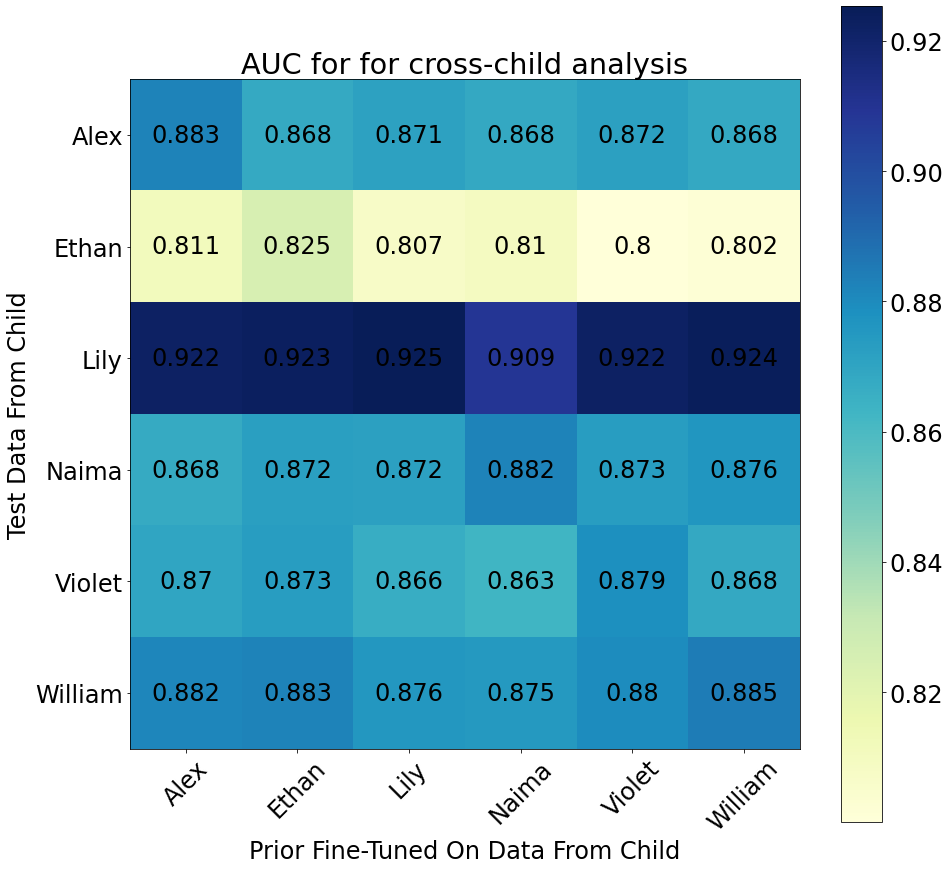

time: 35.8 s (started: 2022-02-05 17:05:35 -08:00)


In [10]:
%R -o cross_scores_short

auc_df = cross_scores_short[['cross_type', 'auc']]
plt.show(analysis.get_heatmap('AUC for for cross-child analysis', analysis.organize_auc_scores_as_grid(auc_df)))

In [11]:
# Not substantively better prediction of successes vs. failures

time: 483 µs (started: 2022-02-05 17:06:11 -08:00)
